# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need her

import os
import emoji
import pandas as pd
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
#!pip install wordcloud
from wordcloud import WordCloud 
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import glob
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
import regex as re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import glob
import mysql.connector
import pandas as pd
import html
import os
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
import regex as re
import glob
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# change `data_location` to the location of the folder on your machine.
#data_location = "/users/rsadeghian/textmining/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
#twitter_folder = "twitter/"
#lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the twitter data

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [58]:
path = "/Users/halledavis/Desktop/twitter/"
os.chdir(path)
twitter_files = os.listdir("/Users/halledavis/Desktop/twitter/")
desc_files = [f for f in twitter_files if "followers_data" in f]
twitter_data = defaultdict(list)
for f in desc_files :
    artist = f.split("_")[0]
        
    with open(path + f,'r', encoding='utf8') as infile :
        next(infile)
        for idx, line in enumerate(infile.readlines()) :
            line = line.strip().split("\t")
            if len(line) == 7 :
                twitter_data[artist].append(line[6])

In [5]:
path = "/Users/halledavis/Desktop/twitter/"
os.chdir(path)

twitter_data = pd.read_csv(artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# Read in the lyrics data

path = "/Users/halledavis/Desktop/lyrics/"
os.chdir(path)

file_list = glob.glob(os.path.join(os.getcwd(), "lilwayne", "*.txt"))

lilwaynelyrics = []

for file_path in file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        lilwaynelyrics.append(
            {
                'Artist': "Lil Wayne",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
lilwaynelyrics = pd.DataFrame(lilwaynelyrics)

In [8]:
file_list = glob.glob(os.path.join(os.getcwd(), "lildicky", "*.txt"))

lildickylyrics = []

for file_path in file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        lildickylyrics.append(
            {
                'Artist': "Lil Dicky",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
lildickylyrics = pd.DataFrame(lildickylyrics)

In [9]:
lyrics = [lilwaynelyrics, lildickylyrics]
lyrics_data = pd.concat(lyrics)

In [10]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

path = "/Users/halledavis/Downloads/"
os.chdir(path)

In [11]:
positive = pd.read_csv('positive-words.txt', header = None)
negative = pd.read_csv('negative-words.txt', header = None)

positive['type'] = 1
negative['type'] = -1

sentiment = pd.concat([positive, negative])

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [13]:
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [14]:
lyrics_data["lyrics"] = lyrics_data["lyrics"].apply(clean)
lilwaynelyrics["lyrics"] = lilwaynelyrics["lyrics"].apply(clean)
lildickylyrics["lyrics"] = lildickylyrics["lyrics"].apply(clean)

In [15]:
pos_score = 1
neg_score = -1
word_dict = {}

for word in positive[0]:
    word_dict[word] = pos_score
    
for word in negative[0]:
    word_dict[word] = neg_score

In [16]:
def sentiment_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return (sentiment_score / len(bag_of_words))

In [22]:
lyrics_data['sentimentscore'] = lyrics_data['lyrics'].apply(sentiment_score)
lilwaynelyrics['sentimentscore'] = lilwaynelyrics['lyrics'].apply(sentiment_score)
lildickylyrics['sentimentscore'] = lildickylyrics['lyrics'].apply(sentiment_score)

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Lil Wayne did.

In [23]:
lyrics_data.groupby('Artist').agg({'sentimentscore':'mean'})

,sentimentscore
Artist,
Lil Dicky,-0.017687
Lil Wayne,-0.003376


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three most negative songs are Fuck the World (which has negative words like thugging, fuck, lying, struggle, scream, curse), Enemy Turf (which has negative words like dying, enemy, fuck, bust, worried), and Hit u Up (which has negative words like die, fuck, glock). The three most positive songs are Tha Block is Hot, Intro Tha Block is Hot, and Drop it Like its Hot. The word hot is on the positive word list and that word is obviously prevalent in all three of these songs.



In [25]:
lilwaynelyrics.sort_values(by=['sentimentscore']).head(3)

,Artist,Song,lyrics,sentimentscore
1,Lil Wayne,lyricslilwaynefucktheworld.txt,"fuck the world Look, look, look A young nigga ...",-0.046809
8,Lil Wayne,lyricslilwayneenemyturf.txt,enemy turf When I say I don't give a fuck I me...,-0.032258
11,Lil Wayne,lyricslilwaynehituup.txt,"hit u up Come on, come on Come on, come on, co...",-0.029151


In [35]:
print(lilwaynelyrics.loc[1]['lyrics'])

fuck the world Look, look, look A young nigga screaming fuck the world and let 'em die Behind tints, tryna duck the world and smoking ride Got my bandanna 'round my head and pants to my feet And got my eyes fire red and Glock on my seat I'm tryna stay under intoxication 'Cause I lost my father, and got a daughter, plus I'm on probation I'm drinking liquor like it's water, getting pissy drunk And staying away from them little broads They're tryna get me stomped keep a chopper in the trunk And my heat on my waistline Ducking the law, 'cause I ain't tryna do no Fed time Sometimes I just wish I could be away But I gotta take care of Ginae and keep Ms. Cita straight So I just maintain the struggle and I keep trying But how can I when my closest people keep dying I ain't lying that the law tryna bust my clique But I scream fuck the world man, I'm too young for this Look, I don't curse, but in this verse man fuck the world I lost my father to a gun and made a little girl And I'm still thuggin

In [36]:
print(lilwaynelyrics.loc[8]['lyrics'])

enemy turf When I say I don't give a fuck I mean that yeah Niggas brains is getting bust I done seen that yeah If a shipment was coming in I need a haul of that wodie I need a sixty-forty nigga And no charging that wodie You done heard about Michael Jackson And shiggidy shit But you ain't never heard about me When I'm flissing a bitch Niggas doors getting knocked Clean off of the hinge See that red dot coming for Me and my girlfriend? 'Cause I wants mine I needs mine And I'm about to get mine But these dying Look little daddy You ain't got to worry about none of these other niggas You needs to be worried about when Juvi coming to get ya Look, I make a phone call to the big dog Y'all bitches better handle y'all business before I hit y'all Even though a nigga rich and I rock ice I still bust a nigga head on the block aight? It's enemy turf that I'm on So I'm 'a play it how it go Cock the hollow points And tote my black calico My little brother Weezy It's enemy turf that I'm on So I'm 'a 

In [37]:
print(lilwaynelyrics.loc[11]['lyrics'])

hit u up Come on, come on Come on, come on, come on, come on, come on I roll with a bunch of untamed guerrillas, head busters, and sharks Niggas that's 'bout beefing – letting them Ks spark Knocking-it-off-your-shoulder soldiers – them real niggas Niggas who did time – hard-to-kill niggas How you live, you get it is the way a nigga play it Niggas ain't fighting no more – niggas busting your head Sending you to your grave – it's do or die, cousin Aiming straight for your head, making sure you die, cousin They're dressing in black, prepared for combat Riding four deep strapped with choppers and macks Not giving a fuck, getting your cut, letting it bust You get hit, that's on you, my nigga – you're outta luck You're stuck like chuck – wodie, you're assed-out That's what happen to you trying to be hard, running your mouth Get erased, my nigga (my nigga) Look here: I leave no trace, my nigga (my nigga) No witnesses so can you see my face, my nigga (my nigga) Fled the scene – so you have no 

In [26]:
lilwaynelyrics.sort_values(by=['sentimentscore']).tail(3)

,Artist,Song,lyrics,sentimentscore
18,Lil Wayne,lyricslilwaynethablockishot.txt,"tha block is hot Wha wha, wha wha, wha wha, wh...",0.035651
12,Lil Wayne,lyricslilwayneintrothablockishot.txt,"intro tha block is hot Ahh, Hot-Hot Yo! Wassup...",0.050360
4,Lil Wayne,lyricslilwaynedropitlikeitshot.txt,"drop it like its hot Drop, drop, drop, what wh...",0.088687


In [38]:
print(lilwaynelyrics.loc[18]['lyrics'])

tha block is hot Wha wha, wha wha, wha wha, wha wha, what Straight off the block, gold nuts in my hand, trusting no man Got my Glock cocked, running this thing, ya understand We be steaming, blazing, nines, pumps and Ks and Hollygrove 17th the hood where I was raised in (what, what, what) Niggas busting heads and, running ducking Feds and (what) Rocks under their tongues and, kis under their beds and Hood full of real niggas, twenty-four seven hustlers (Ugh) Until we shove a barrel down ya pipe suckers Ain't no love for no buster, no fear for no coward No respect for no slut, and no money without power We keeping niggas hotter, ugh, nasty and sour Pile up in the Eddie Bauer and "blocka" at every hour Some niggas like that powder, folding up with that drain Some like that weed or that dope and some shoot it up in their veins (oh) From the home of that 'caine, jacking and cracking brains Broadcasting live from Tha Block, it's Lil' Wayne (who it is?) Nigga, you got that yayo? (Well cook s

In [40]:
print(lilwaynelyrics.loc[12]['lyrics'])

intro tha block is hot Ahh, Hot-Hot Yo! Wassup?! What it be like, Fresh? What's happenin'? It's all gravy, baby It's gorgeous And Tha Block Is Hot; what's up, nigga? Aww man, it's magnificent, magnificent Look, nigga, my block so hot when my hoes walk, them diamonds poppin' out they toenail, woadie Bling-bling, bling-bling But it's all gravy Ya heard me? The block is full of lava, nigga (Ha) Got them po-po's pullin' up actin' crazy, nigga, what's happenin'? Tha Block Is Hot, like a barbeque at Satan's crib (Off top, I'm loving that) Tha Block Is Hot, like the Delgado Clinic, ya' heard me This lil' nigga Wayne is so motherfuckin' on fire (Wayne is gorge-rific!) A hose pipe couldn't put this nigga out Man, Baby, have a heart, have a heart This lil' nigga here is greasy (Have a heart) He cheesy (Have a heart) This lil 4 foot millionaire is on fire, woadie Aww man, that's wonderful And he know he representin' with the motherfuckin' Big Tymers B. Geezy, Turk, Juvey, come to lay it down, nig

In [39]:
print(lilwaynelyrics.loc[4]['lyrics'])

drop it like its hot Drop, drop, drop, what what what After you back it up then stop What What, what, drop it like it's hot After you back it up and stop What, what What, drop it like it's hot Now drop it like it's hot, drop drop it like it's Hot Drop it like it's hot, drop drop it like it's hot Make 'em drop it Like it's hot, drop drop it like it's hot Drop it like it's hot, drop drop it Like it's hot Hehe, listen You know me girl I'm a Cash Money millionaire, look at my Rolie (Rolex) girl Drop to your knees toss your hair ahah slow me girls Now hit it strong, won't be long, now catch it slowly girl No he didn't say that, yes I did girl I don't use rubbers, and I don't plan no kids girl I don't want your number, I want your draws and ya skins girl Then after that, you can get it how you live girl That's on the real girl, I'm a pimp girl Get it twisted, I'll slam you like Shawn Kemp girl I'm the one to get it hot like a lighter girl I just slap you a couple of times, never fight it gir

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three most negative songs are Grimy as a Gooch (which has words like afraid, fuck, fear, pissin, shittin, sick, bitches), How Can I Become a Bawlaa (which has words like steal, shit, bitches, homicidal), and Too High (which has words like fucking, disgusting, deranged, and pathetic). The three most positive songs are Sky Hooks, The Cypher, and Sports (which has words like better, superstar, love, good).

In [27]:
lildickylyrics.sort_values(by=['sentimentscore']).head(3)

,Artist,Song,lyrics,sentimentscore
11,Lil Dicky,lyricslildickygrimyasagooch.txt,grimy as a gooch Iont fuck around I been getti...,-0.052202
13,Lil Dicky,lyricslildickyhowcanibecomeabawlaa.txt,how can i become a bawlaa Ridin' round smoking...,-0.047742
12,Lil Dicky,lyricslildickytoohigh.txt,"too high Wassup, wassup y'all L-D aka Young Di...",-0.041667


In [41]:
print(lildickylyrics.loc[11]['lyrics'])

grimy as a gooch Iont fuck around I been getting down Not afraid to eat some triscuits up off the ground 5 second rule? I'm on that 5 year A lotta guys fear what I got in my ears (wax) If I ain't pissin then you know I'm shittin bricks Do it sick, when I finish homie I ain't washin shit Shaved dick, shave with, same shit, face get Bitches sittin on ma pillows and they butt naked Lickin grease off of that pizza And these mafuckas prolly want a paper towel Errybody know that I rape toenails When I pick, then I flick em on the straight up ground now Ain't shit to a mafuckan balla Mo grit than a mafuckan dolla Come back from ballin, you gotta smell sack Yea it's that appalling And Ion't ever wash ma feet When I'm in the shower, they be hard to reach When I'm getting down, goin out on the weekend I'm asleep before I brush my teeth I'm a goddamn G tho Mo grime than Ed Reed's pee hole Mo grime than Ronaldhino These other rappers can't deny it Cause I don't even act like a thug But I'm cold en

In [42]:
print(lildickylyrics.loc[13]['lyrics'])

how can i become a bawlaa Ridin' round smoking weed with ma foreign bitch Ridin' round smoking weed with ma foreign bitch Ma window down, I'm riding to ma new shit (wish dat was me) Got ma new bitch, got ma, got ma new bitch (this dude a g!) Ion't camp off with no j's they sell them hoes for free (what the fuck that mean?) Never payin for no pussy, fuck them hoes for free That's a fucking bawlaa How can I become a bawlaa? Mirror mirror on the wall How can dicky learn to ball I wish I was TIP and I could spit some shit with southern drawls I wish I could flip a brick and spit dat shit like Ricky Ross Holla at broads, at the mall Spit about a mafuckan bitch up in da wip And getting lit up in the backseat Talkin shit about a dinner with an athlete Fuck that, can't rap like the rest of these mafuckas Without all ma writtens being fact free Do y'all know how bad I wish I could But y'all would laugh if I spit hood So now ya man is making jams about some random Shit, when dudes is rappin bout

In [43]:
print(lildickylyrics.loc[12]['lyrics'])

too high Wassup, wassup y'all L-D aka Young Dick Had to make a track about smoking weed, man Every rapper got a track about smoking weed so I didn't really have a choice But, I guess I made mine a little bit different is all It's like, it's like, it's like Blowin something sticky word to pre-cum dicks I'm with ma team in this bitch, and we all getting lit I mean the weed hella loud, like a teenage chick And we been smoking for a minute, yeah we blowin on that ganja And now I'm huffin and puffin, I'm choking on that bong And the dope I'm on is bomb I'm smoking that Vietcong Getting real high Watching funny videos of bill nye Tell me that this jam isn't still fly Bill nye theme song Now I'm getting hungry than a muthafucka Put some chicken nuggets in the oven at 400 Whered I put that honey mustard Lookin all around the cupboard for that muthafucka Until I discovered a custard, I covered with butter from last week. How long do them thangs keep? Guess I better ask jeeves Go get ma computer

In [28]:
lildickylyrics.sort_values(by=['sentimentscore']).tail(3)

,Artist,Song,lyrics,sentimentscore
2,Lil Dicky,lyricslildickyskyhooks.txt,"sky hooks Alrite, this the type a shit they be...",0.001326
6,Lil Dicky,lyricslildickythecypher.txt,the cypher See back in highschool I ain't even...,0.010178
14,Lil Dicky,lyricslildickysports.txt,sports Shots in the club like plaxico I'm in t...,0.034549


In [44]:
print(lildickylyrics.loc[2]['lyrics'])

sky hooks Alrite, this the type a shit they be playin at the barbershop I hear these mafuckas saying that it's all for naught But I ain't stopping till I make it to the top y'all They bout to feel stupid talking like a dropped call Cause I'm bout to pop off ma dude, the flow too cashy And this white dude ain't trashy I'm actually college educated, U of R abbreviated, Got inebriated but ma GPA was still amazing On that 3.93 tip, fuck you know about a Eastside G spittin uncontrollable I mean if clever is the measure, then I'm better than Whatever rapper's getting cheddar, I'm the king, and they corretta They some bitches like a kennel got, Dicky spittin devil hot Listenin to ma writtens gotchu whistlin like a kettle potttt I can't stop till I make a dent But this is greatness, take it in Ya namsayin cause Ya'll mafuckas wanna be that kid Wanna lease that wip Wanna be that sick Das a mafucka in this mafucka getting dough Like a mafucka in this mafucka whatchu know bout a Late teen with dr

In [45]:
print(lildickylyrics.loc[6]['lyrics'])

the cypher See back in highschool I ain't even know I could rap So the hits late, but nobody throwin the flag Goin fifth grade with it, Dicky opening snacks Because the kid made different like a joke in Iraq Now check it Never thought I wanna pass the bar But I gotta get fancy car So I got up on the beat, beat on it like Evander sparring partner, smarter art When I master bars These weak bitches gotta leave, dicky dissin' em all To listen to y'all is sorta like a flick in the balls Foreal tho Cause they don't spit it real as D do The kid come first, like his dick a prequel, so look If you really wanna get it, forget it, genetically better Then every pathetic competitor nettin cheddar Get in bed I'll get you wetter than Redick I bet I bend her, get her beggin, etcetera Breath, now ya man on reddit cause I'm rappin the flames I'm hands on, wayne chrebet, when I'm mackin the dames tho The lame bros, better learn to make a single Or ya mayn bout to have these rappers playin some bingoooo..

In [46]:
print(lildickylyrics.loc[14]['lyrics'])

sports Shots in the club like plaxico I'm in the corner, hot like Placido's And dicky fuckin flow nuts pistachio And like Shelvin, I know how to mack a ho I got girls on ma penis Flow is the meanest Not Gilbert, but I'm sellin out arenas Do it all day A peterson Because I'm tryna get paid like Revis did I met a French bitch, big lips, and she got a body Told her put that ass on moi like nnamdi Fight like rocky, white like Roddy Hoosier Daddy all knight like Booby Hot box ride, I can barely see You know I keep ma car melo like Anthony Got bigger blunts than legarrete, smoke outta Taurus Put Mar kief in dat philly like Morris Anybody better better than me, good try I'm the best like Jahvid, but I'm not lion Not even a tyson... no ear biting Ma pockets fat with green, so Rex Ryan I ball for the bucks like Luc Richard Mbah a Moute, But I'm a fuckin superstar And if they ask LD where he wanna live Then I'm a tell 'em where markakis like Nick. I'm tryna get a little Kevin Love And then I see

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: 

Artist
Lil Dicky    AxesSubplot(0.125,0.125;0.775x0.755)
Lil Wayne    AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentimentscore, dtype: object

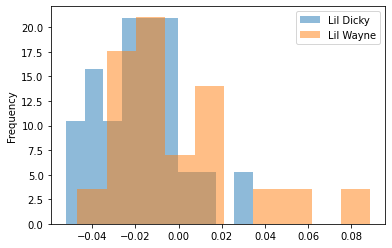

In [47]:
lyrics_data.groupby('Artist')['sentimentscore'].plot(kind="hist",density=True,alpha=0.5,legend=True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [49]:
punctuation = set(punctuation) # speeds up comparison
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

pipeline = [str.lower, tokenize, remove_stop]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [62]:
twitterdf = pd.DataFrame([(k, x) for k, v in twitter_data.items() for x in v], columns=['artist','description'])
twitterdf['tokens'] = twitterdf['description'].apply(prepare, pipeline=pipeline)
chertweets = twitterdf[twitterdf["artist"] == "cher"]
robyntweets = twitterdf[twitterdf["artist"] != "cher"]

In [67]:
contains_emoji = []
emojis = []
            
for row in chertweets['description']:
    emoji_found = False
    for char in row:
        if emoji.is_emoji(char):
            emoji_found = True
            emojis.append(char)
    contains_emoji.append(emoji_found)

chertweets['has_emoji'] = contains_emoji

/var/folders/4w/bl1whnz1491dljnl9k34l06h0000gn/T/ipykernel_59369/1852858735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chertweets['has_emoji'] = contains_emoji


In [68]:
cheremojis = emojis
cheremojis = pd.DataFrame(cheremojis, columns=['emojis'])

In [73]:
cheremojis

,emojis
0,💜
1,🍒
2,💓
3,🧡
4,🖤
...,...
1155297,🎮
1155298,🌴
1155299,🔮
1155300,🐕


In [71]:
contains_emoji = []
emojis = []
            
for row in robyntweets['description']:
    emoji_found = False
    for char in row:
        if emoji.is_emoji(char):
            emoji_found = True
            emojis.append(char)
    contains_emoji.append(emoji_found)

robyntweets['has_emoji'] = contains_emoji

/var/folders/4w/bl1whnz1491dljnl9k34l06h0000gn/T/ipykernel_59369/2594886227.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robyntweets['has_emoji'] = contains_emoji


In [72]:
robynemojis = emojis
robynemojis = pd.DataFrame(robynemojis, columns=['emojis'])

In [77]:
n = 10
print("Top Cher Emojis")
print(cheremojis['emojis'].value_counts()[:n].index.tolist())
print("\n Top Robyn Emojis")
print(robynemojis['emojis'].value_counts()[:n].index.tolist())

Top Cher Emojis
['❤', '🌈', '♥', '🏳', '✨', '💙', '🏻', '🌊', '✌', '💜']

 Top Robyn Emojis
['❤', '🌈', '🏳', '♥', '✨', '🏻', '✌', '🏼', '♀', '💙']


In [88]:
pos_score = 1
neg_score = -1
emojidict = {}

emojidict["🤡"] = neg_score
emojidict["😠"] = neg_score
emojidict["😭"] = neg_score
emojidict["💀"] = neg_score
emojidict["😖"] = neg_score
emojidict["💢"] = neg_score
emojidict["❌"] = neg_score
emojidict["😑"] = neg_score
emojidict["😓"] = neg_score
emojidict["✋"] = neg_score



emojidict["💜"] = pos_score
emojidict["🌈"] = pos_score
emojidict["❤"] = pos_score
emojidict["♥"] = pos_score
emojidict["✨"] = pos_score
emojidict["✌"] = pos_score
emojidict["❤️"] = pos_score
emojidict["😍"] = pos_score
emojidict["👯"] = pos_score
emojidict["💞"] = pos_score



In [89]:
emojidict

{'🤡': -1,
 '😠': -1,
 '😭': -1,
 '💀': -1,
 '😖': -1,
 '💢': -1,
 '❌': -1,
 '😑': -1,
 '😓': -1,
 '✋': -1,
 '💜': 1,
 '🌈': 1,
 '❤': 1,
 '♥': 1,
 '✨': 1,
 '✌': 1,
 '❤️': 1,
 '😍': 1,
 '👯': 1,
 '💞': 1}

In [90]:
def emoji_sentiment_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in emojidict:
            sentiment_score += emojidict[word]
    return (sentiment_score / len(bag_of_words))

In [91]:
cheremojis['sentimentscore'] = cheremojis['emojis'].apply(emoji_sentiment_score)
robynemojis['sentimentscore'] = robynemojis['emojis'].apply(emoji_sentiment_score)

In [92]:
cheremojis["sentimentscore"].mean()

0.19885017077785722

In [93]:
robynemojis["sentimentscore"].mean()

0.21578323803636737

In [96]:
positivecheremojis = cheremojis[cheremojis["sentimentscore"] == 1.0]
negativecheremojis = cheremojis[cheremojis["sentimentscore"] == -1.0]
positiverobynemojis = robynemojis[robynemojis["sentimentscore"] == 1.0]
negativerobynemojis = robynemojis[robynemojis["sentimentscore"] == -1.0]


In [97]:
positivecheremojis['emojis'].value_counts()

emojis
❤    79223
🌈    47549
♥    33978
✨    29468
✌    16773
💜    16550
😍     8189
💞     3291
👯      388
Name: count, dtype: int64

In [98]:
negativecheremojis['emojis'].value_counts()

emojis
💀    1808
❌    1065
🤡    1023
😭     730
✋     580
😑     183
😠     115
💢      68
😖      54
😓      51
Name: count, dtype: int64

In [99]:
positiverobynemojis['emojis'].value_counts()

emojis
❤    4783
🌈    4685
♥    3103
✨    2223
✌    1189
💜     739
😍     264
💞      88
👯      26
Name: count, dtype: int64

In [100]:
negativerobynemojis['emojis'].value_counts()

emojis
💀    126
❌     74
🤡     52
😭     41
✋     28
😑      9
😠      6
💢      4
😓      4
Name: count, dtype: int64

Q: What is the average sentiment of your two artists? 

A: Cher's average is 0.19 and Robyn's is 0.21.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The little black heart is the most popular positive emoji for both artists, and the skull is themost popular negative emoji for both artists.

